In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from bepsf.image import *
from bepsf.psfmodel import *
from bepsf.utils import *
from bepsf.infer import *

In [2]:
import matplotlib.pyplot as plt
import corner
import pandas as pd
from arviz import plot_trace
from jax import config
config.update('jax_enable_x64', True)

In [3]:
plt.rcParams['figure.dpi'] = 150

In [4]:
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image
from photutils.detection import DAOStarFinder

In [5]:
def find_sources(data, sort=True, plot=True, Nplot=20, norm='log', extent=None):
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
    #print((mean, median, std))  
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources = daofind(data - median).to_pandas()
    if sort:
        sources = sources.sort_values("flux", ascending=False).reset_index(drop=True)
    if plot:
        # 1st index: row, 2nd index: col
        xcs, ycs = np.array(sources[['xcentroid', 'ycentroid']]).T
        plt.figure()
        plt.imshow(data[:,:], origin='lower')#, norm=norm)
        plt.plot(xcs[:Nplot], ycs[:Nplot], '.', marker='o', mfc='none', color='tan')
        plt.colorbar(label='count')
    return sources

def plot_individual_sources(data, sources, width=20, norm='log', extent=None):
    xcs, ycs = np.array(sources[['xcentroid', 'ycentroid']]).T
    for xc, yc in zip(xcs, ycs):
        d_ = data[int(np.fmax(yc-0.5*width,0)):int(yc+0.5*width),int(np.fmax(xc-0.5*width,0)):int(xc+0.5*width)]
        plt.figure()
        plt.xlim(xc-0.5*width, xc+0.5*width)
        plt.ylim(yc-0.5*width, yc+0.5*width)
        plt.imshow(data, origin='lower', vmax=np.max(d_)*1.1)#, norm=norm)
        #plt.imshow(d_, origin='lower')#, norm=norm)
        plt.colorbar()

In [6]:
hdul = fits.open("magO_MB116_kp_tdOpen.fits")
data_raw = hdul[0].data

## original image

/tmp/ipykernel_1441745/3407285900.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(data_raw), origin='lower')
/tmp/ipykernel_1441745/3407285900.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data_raw), origin='lower')


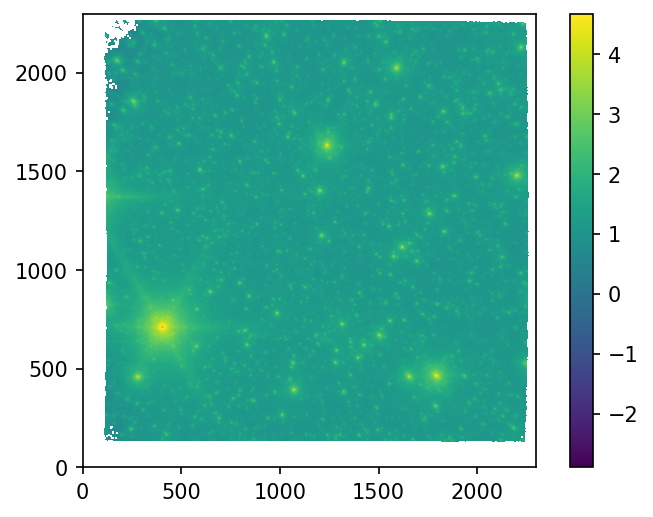

In [7]:
plt.imshow(np.log10(data_raw), origin='lower')
plt.colorbar()

## cutout

In [8]:
xmin, xmax, ymin, ymax  = 1000, 1500, 1000, 1500
#xmin, xmax, ymin, ymax  = 800, 1700, 800, 1700
imgext = [xmin, xmax, ymin, ymax]
d_cut = data_raw[ymin:ymax,xmin:xmax]
x_targ, y_targ = 1210 - xmin, 1175 - ymin

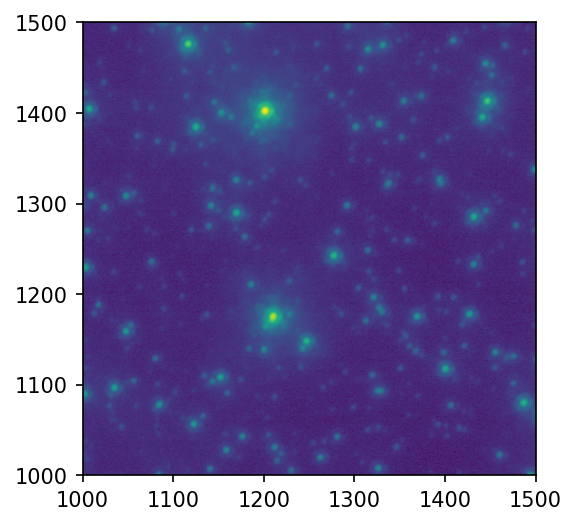

In [9]:
plt.imshow(np.log10(d_cut), origin='lower', extent=imgext)

## find bright sources using DAOStarFinder

/tmp/ipykernel_1441745/813589198.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(xcs[:Nplot], ycs[:Nplot], '.', marker='o', mfc='none', color='tan')


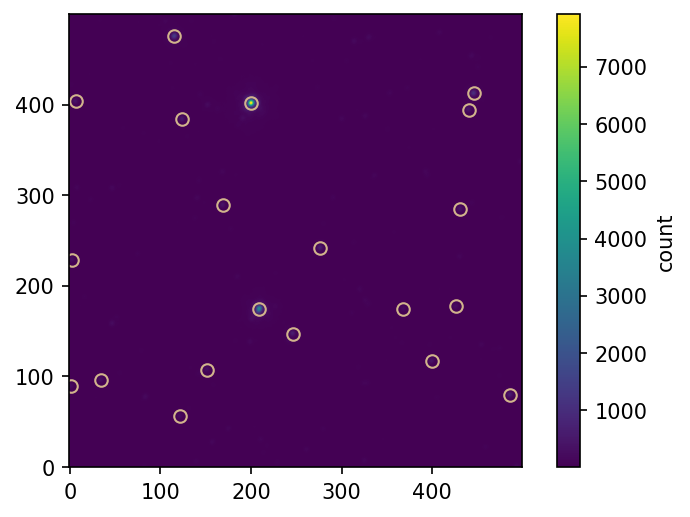

In [10]:
s_cut = find_sources(d_cut, Nplot=20, extent=imgext)

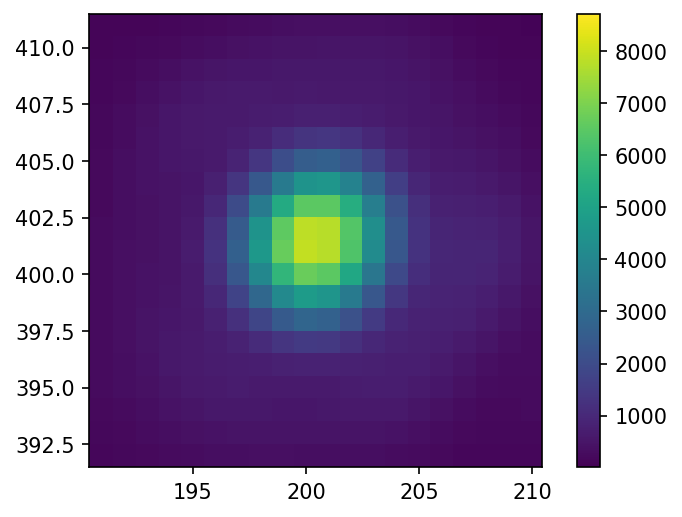

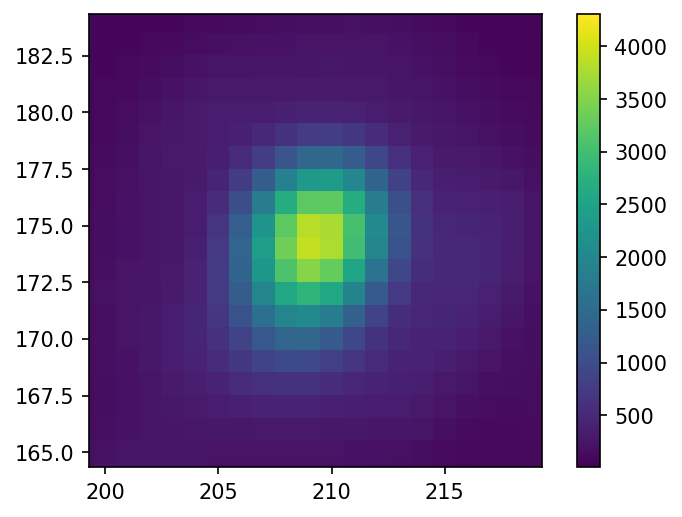

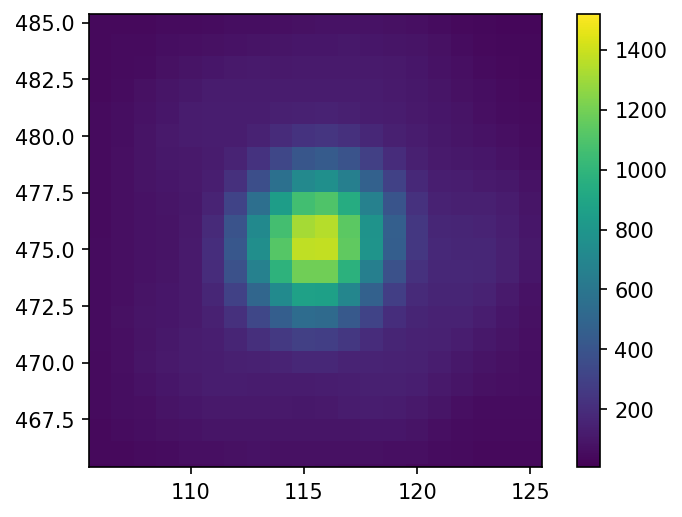

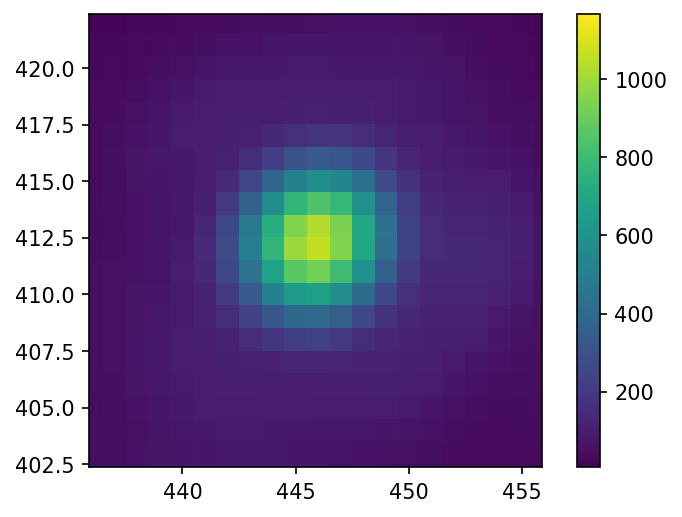

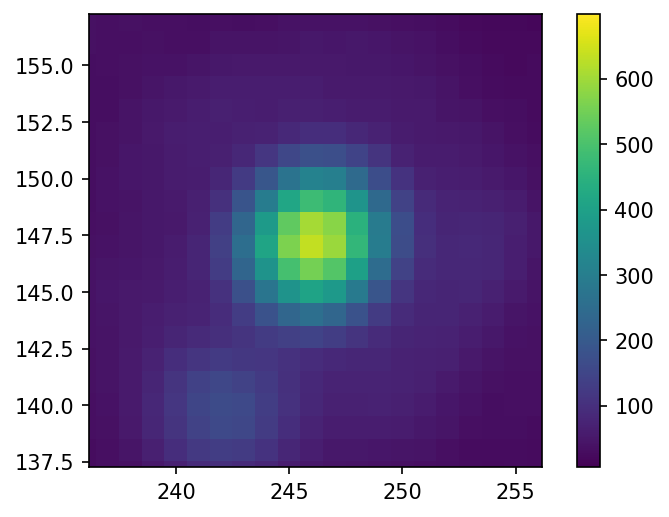

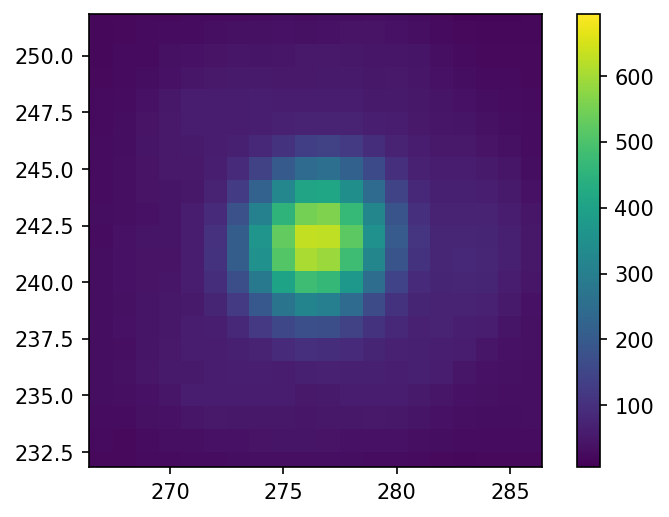

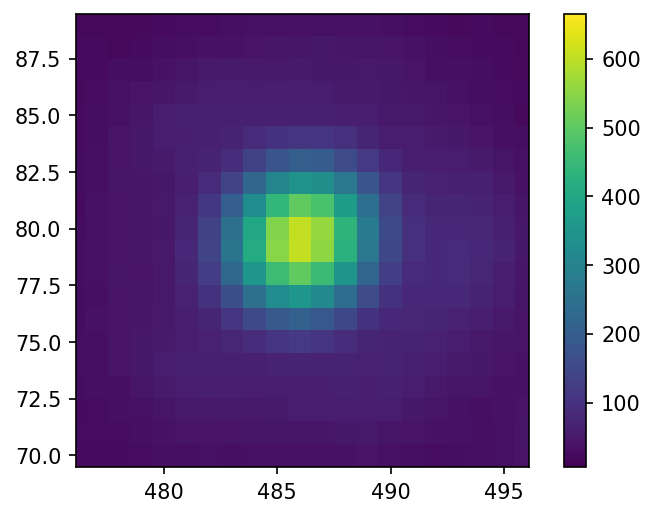

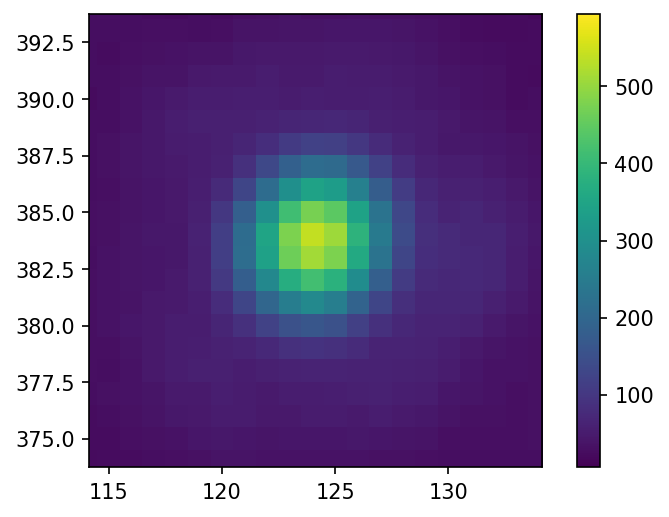

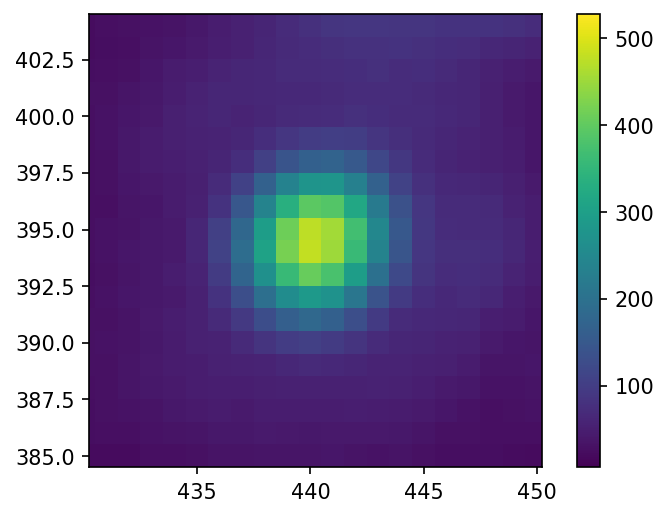

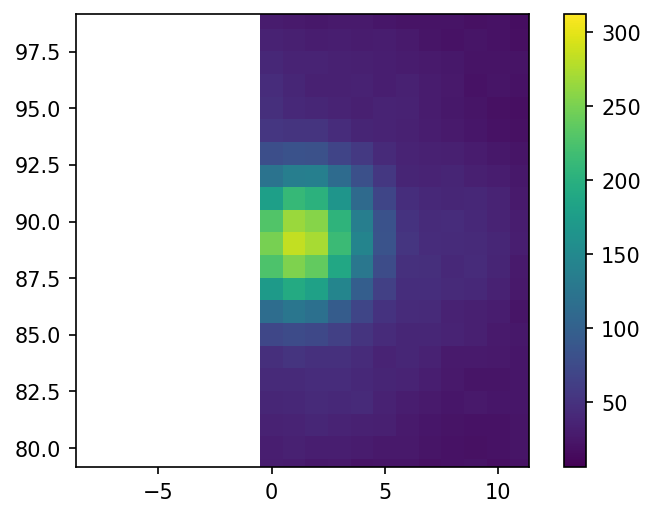

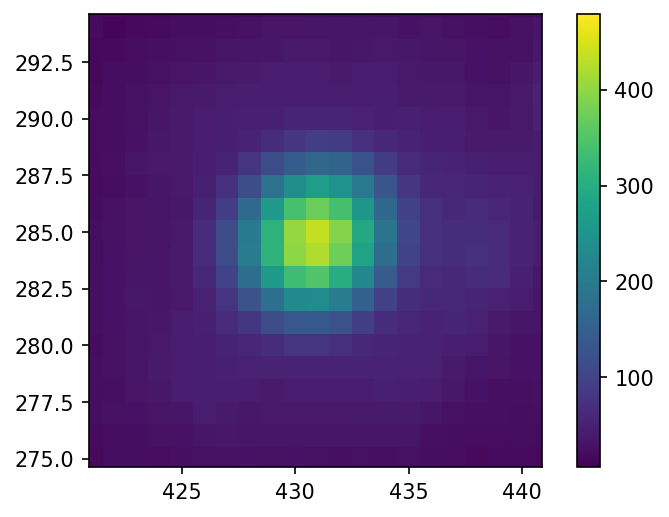

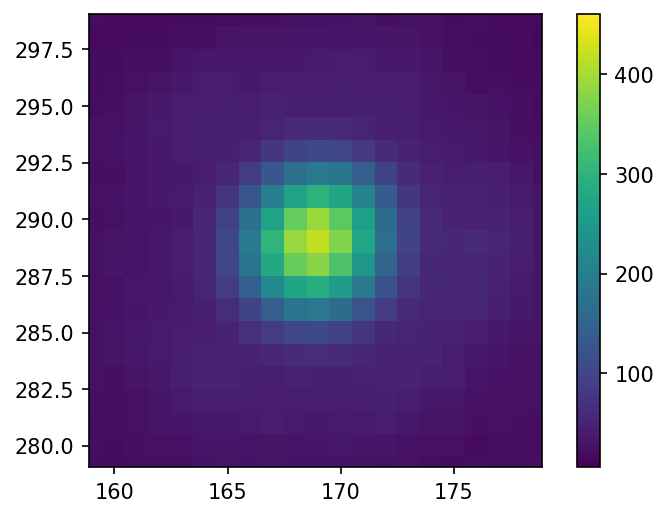

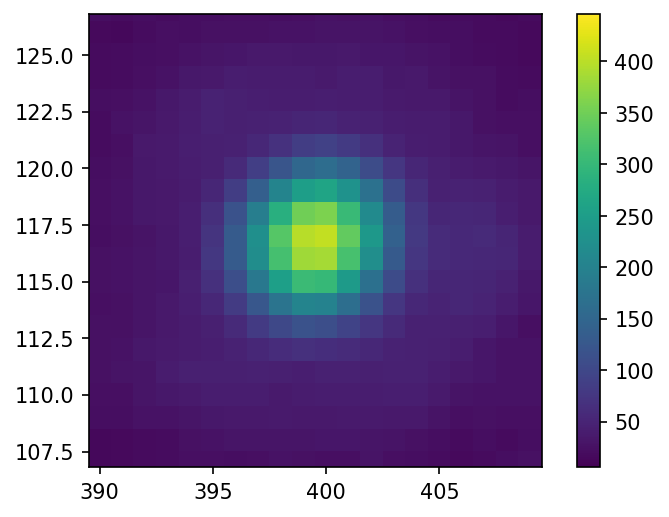

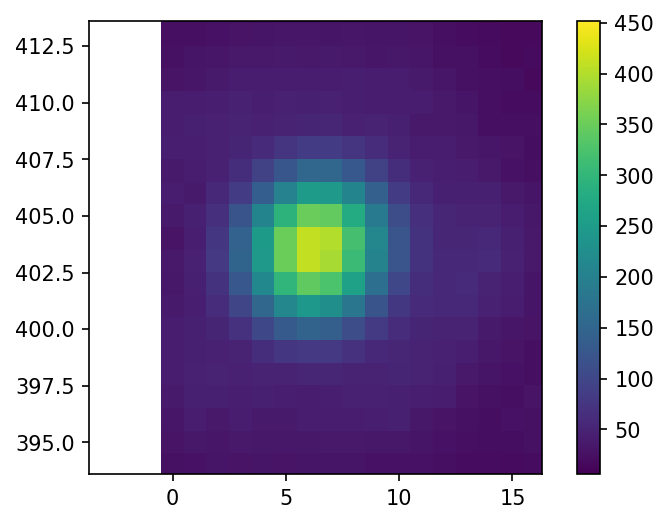

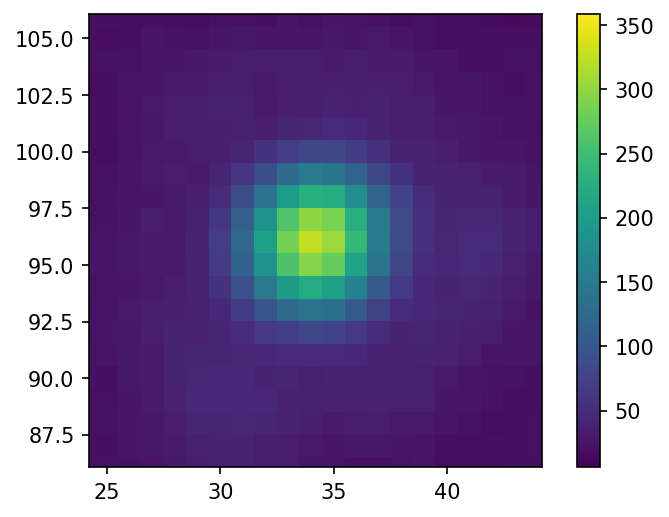

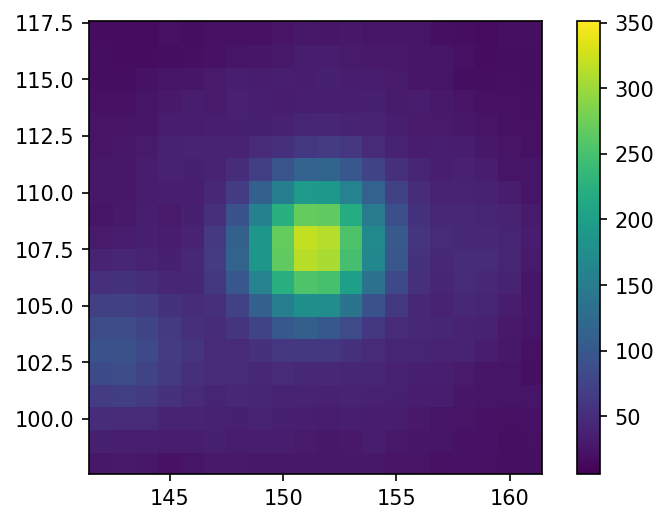

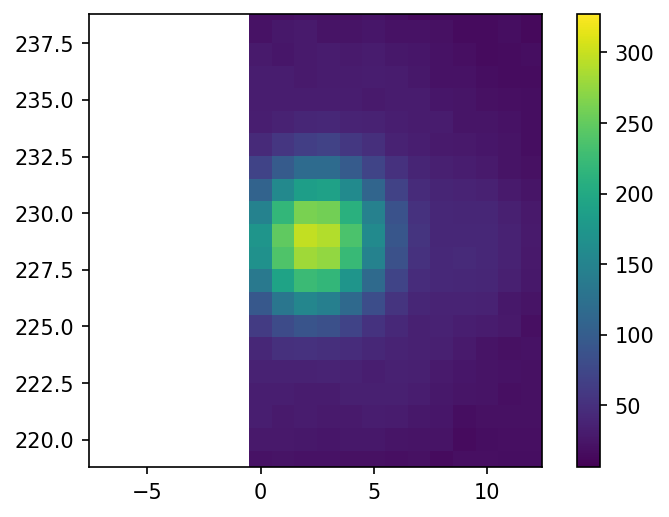

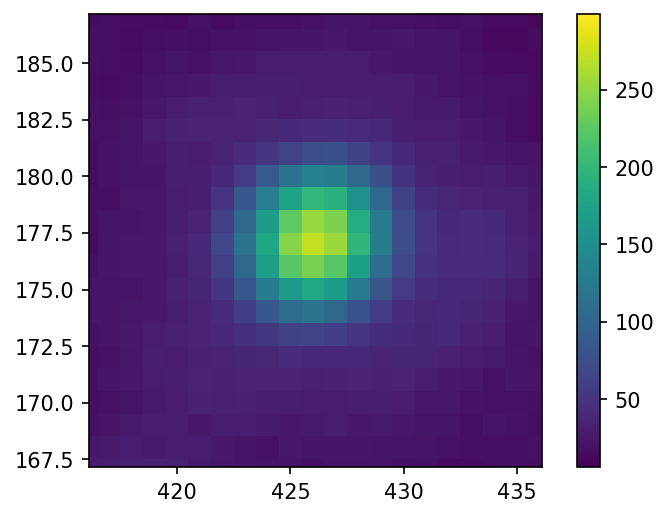

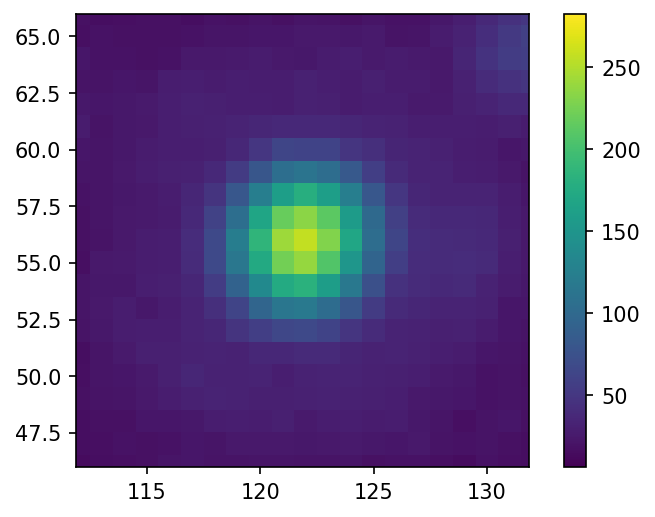

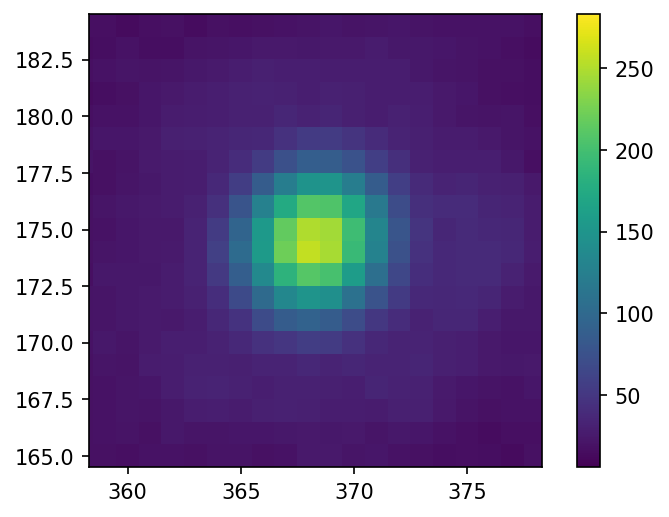

In [11]:
plot_individual_sources(d_cut, s_cut.iloc[:20], norm='linear')

In [12]:
dataZ = d_cut - np.median(d_cut)

In [13]:
image_obs = PixelImage(*np.shape(dataZ))
image_obs.Z = dataZ
image_obs.Zerr = np.sqrt(d_cut) #/ 2.

In [14]:
N_sources = 20
#N_sources = 15
#N_sources = 10

In [15]:
xcenters, ycenters = np.array(s_cut[['xcentroid', 'ycentroid']])[:N_sources].T
source_half_extent = 12

## remove the target and doubles

In [19]:
drop_idxs = []
for i, (x, y) in enumerate(zip(xcenters, ycenters)):
    distances = np.sqrt((s_cut.xcentroid-x)**2 + (s_cut.ycentroid-y)**2)
    distance_targ = np.sqrt((x-x_targ)**2 + (y-y_targ)**2)
    idx = ((distances > np.min(distances)) & (distances < source_half_extent))
    if np.sum(idx) or (distance_targ < source_half_extent):
        drop_idxs.append(i)
        #x_, y_ = np.array(s_cut[idx][['xcentroid', 'ycentroid']]).T
        #xcenters = np.append(xcenters, x_)
        #ycenters = np.append(ycenters, y_)

In [20]:
drop_idxs

[1, 4, 15]

In [21]:
#xcenters, ycenters = np.delete(xcenters, 2, 0), np.delete(ycenters, 2, 0)
xcenters, ycenters = np.delete(xcenters, drop_idxs, 0), np.delete(ycenters, drop_idxs, 0)

In [22]:
xcenters, ycenters

(array([200.42867299, 115.52336183, 445.88144419, 276.42367414,
        486.10857505, 124.14473486, 440.23507541,   1.35597272,
        430.9016864 , 168.89245922, 399.53880572,   6.31180581,
         34.20984318,   2.43042473, 426.11562612, 121.86220039,
        368.30913251]),
 array([401.47372391, 475.36989639, 412.36498153, 241.82418109,
         79.46214658, 383.73988013, 394.49716912,  89.1437951 ,
        284.60996412, 289.04862619, 116.79843674, 403.58818588,
         96.06040108, 228.77389659, 177.14581269,  55.97073052,
        174.50108518]))

## image mask

In [23]:
image_obs.define_mask(xcenters, ycenters, source_half_extent)

## initial guess for positions and fluxes

In [24]:
fap, xap, yap = image_obs.aperture_photometry(xcenters, ycenters, source_half_extent)
image_obs.lnfinit = np.log(np.array(fap))
image_obs.xinit = xap
image_obs.yinit = yap

In [25]:
'''
image_obs.idx_anchor = choose_anchor(image_obs, xcenters, ycenters, lnfluxes=np.log(fluxes), 
                                     plot=True, mad_threshold=10)
'''
idx_anchor = 0
image_obs.idx_anchor = idx_anchor

### make sure that the anchor is an isolated source and is not around the edge

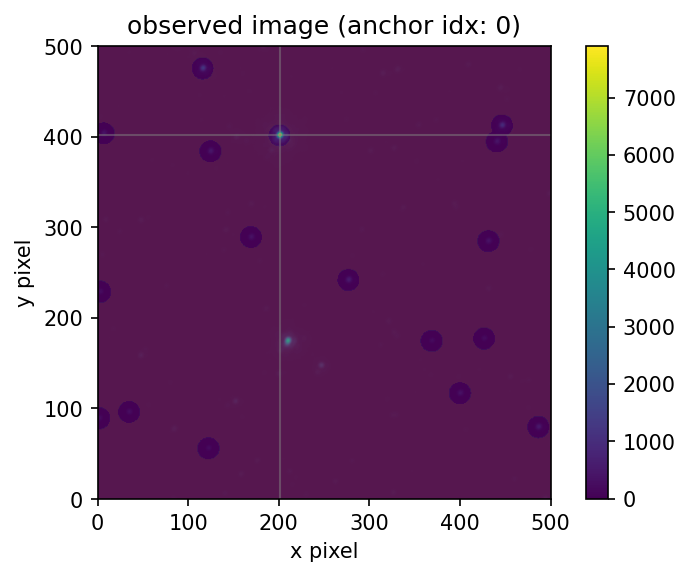

In [26]:
check_anchor(image_obs)

## define grid PSF model

In [27]:
psf_full_extent = source_half_extent * 2.2
dx, dy = 1./2., 1./2.
gridpsf = GridePSFModel(psf_full_extent, psf_full_extent, dx, dy)

PSF grid shape: (53, 53)
grid edge: x=[-13.250000, 13.250000], y=[-13.250000, 13.250000]
grid center: x=0.000000, y=0.000000


## optimization

In [28]:
%%time
res = optimize(gridpsf, image_obs, xyclim=[-0.5*source_half_extent, 0.5*source_half_extent])
popt, state = res
popt = drop_anchor(popt, image_obs.idx_anchor)

# optimizing flux and position...
ScipyMinimizeInfo(fun_val=DeviceArray(23351.55760301, dtype=float64), success=False, status=4, iter_num=11, hess_inv=None)

# optimizing GP parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(22889.38908692, dtype=float64), success=True, status=1, iter_num=7, hess_inv=None)

# optimizing all parameters...
ScipyMinimizeInfo(fun_val=DeviceArray(22321.24063123, dtype=float64), success=False, status=3, iter_num=24, hess_inv=None)
CPU times: user 3min 40s, sys: 17.3 s, total: 3min 57s
Wall time: 3min 53s


In [29]:
mask1d = image_obs.mask1d
epsf1d_pred, _image1d_pred = gridpsf.predict_mean(popt['fluxes'], popt['xcenters'], popt['ycenters'], 
                            jnp.exp(popt['lnlenx']), jnp.exp(popt['lnleny']), jnp.exp(2*popt['lnamp']), jnp.exp(popt['lnmu']),
                            image_obs.X1d[~mask1d], image_obs.Y1d[~mask1d], image_obs.Z1d[~mask1d], image_obs.Zerr1d[~mask1d])
image1d_pred = np.zeros(image_obs.size)
image1d_pred[~mask1d] = _image1d_pred

In [30]:
ds = 0.5
x_offset = image_obs.xinit[image_obs.idx_anchor] - xcenters[image_obs.idx_anchor]
y_offset = image_obs.yinit[image_obs.idx_anchor] - ycenters[image_obs.idx_anchor]
finegrid = GridePSFModel(psf_full_extent, psf_full_extent, dx=ds, dy=ds)
epsf_pred = gridpsf.evaluate_ePSF(finegrid.X, finegrid.Y, x_offset, y_offset, epsf1d_pred)
#true_epsf = compute_epsf(finegrid, truepsffunc, dict(**{"norm": 1., "xc": 0, "yc": 0}, **truepsfkws))

PSF grid shape: (53, 53)
grid edge: x=[-13.250000, 13.250000], y=[-13.250000, 13.250000]
grid center: x=0.000000, y=0.000000


## inferred ePSF

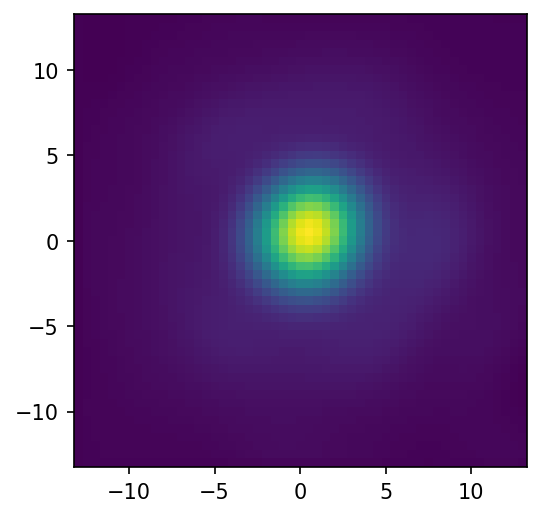

In [33]:
plt.imshow(epsf_pred, origin='lower', extent=[
                              gridpsf.xgrid_edge[0], gridpsf.xgrid_edge[-1],
                              gridpsf.ygrid_edge[0], gridpsf.ygrid_edge[-1]
                          ])

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import median_abs_deviation
def check_image_fit(image_obs, image_pred):
    """ compare observed image and inferred true image """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    mask, mask1d = image_obs.mask, image_obs.mask1d
    residual_image = image_obs.Z - image_pred.reshape(*image_obs.shape)
    residual_image = np.where(mask, np.nan, residual_image)
    im = ax[0].imshow(residual_image,
                      origin='lower',
                      extent=[
                          image_obs.xgrid_edge[0], image_obs.xgrid_edge[-1],
                          image_obs.ygrid_edge[0], image_obs.ygrid_edge[-1]
                      ])
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    #ax[0].imshow(image_obs.mask, alpha=0.1)
    ax[0].set_title('data minus mean prediction')
    ax[0].set_xlim(image_obs.xgrid_edge[0], image_obs.xgrid_edge[-1])
    ax[0].set_ylim(image_obs.ygrid_edge[0], image_obs.ygrid_edge[-1])
    residual1d = np.array(image_obs.Z1d - image_pred) / image_obs.Zerr1d
    ax[1].hist(residual1d[~mask1d],
               histtype='step',
               lw=1,
               bins=30,
               density=True)
    ylim = ax[1].get_ylim()
    ax[1].set_yscale("log")
    ax[1].set_xlim(-5, 5)
    ax[1].set_ylim(None, ylim[1] * 1.2)
    x0 = np.linspace(-5, 5, 100)
    ax[1].plot(x0,
               np.exp(-0.5 * x0**2) / np.sqrt(2 * np.pi),
               color='gray',
               lw=1, label='standard normal')
    ax[1].set_xlabel("residual normalized by error")

## residual distribution

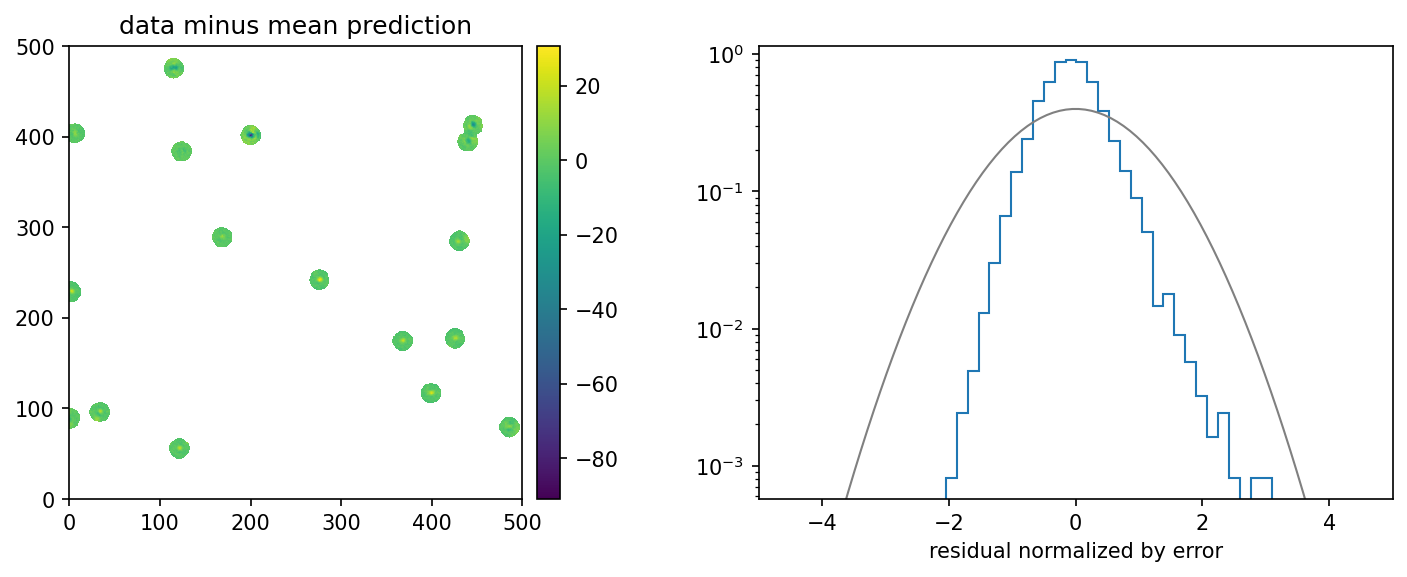

In [35]:
check_image_fit(image_obs, image1d_pred)

In [36]:
residual_image = image_obs.Z - image1d_pred.reshape(*image_obs.shape)
residual_image = np.where(image_obs.mask, 0., residual_image) / image_obs.Zerr

## residual divided by error

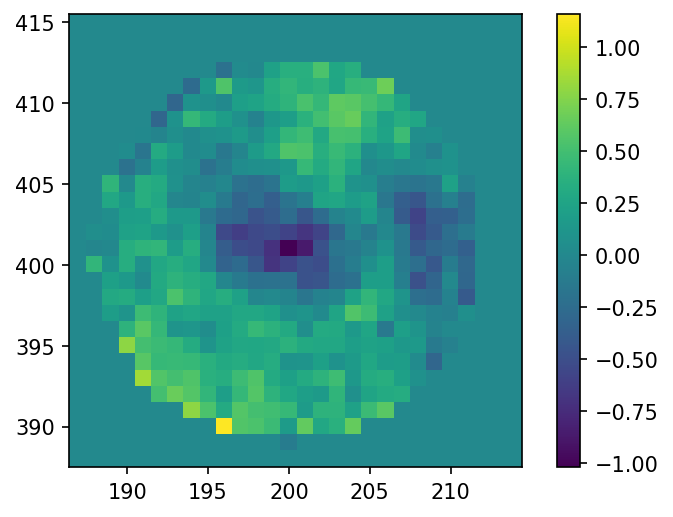

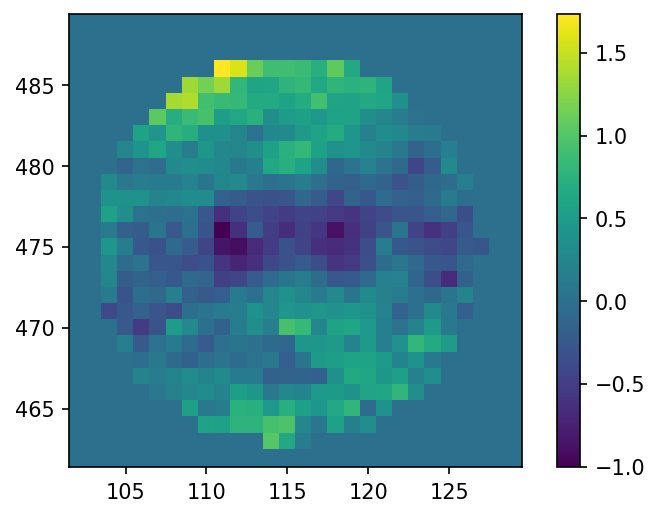

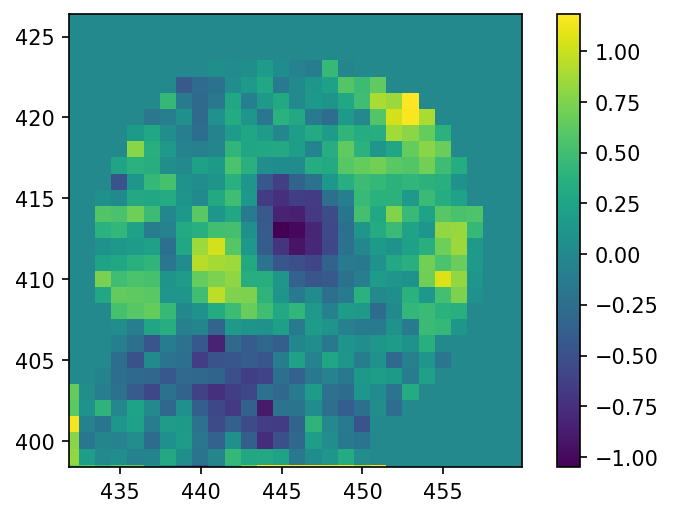

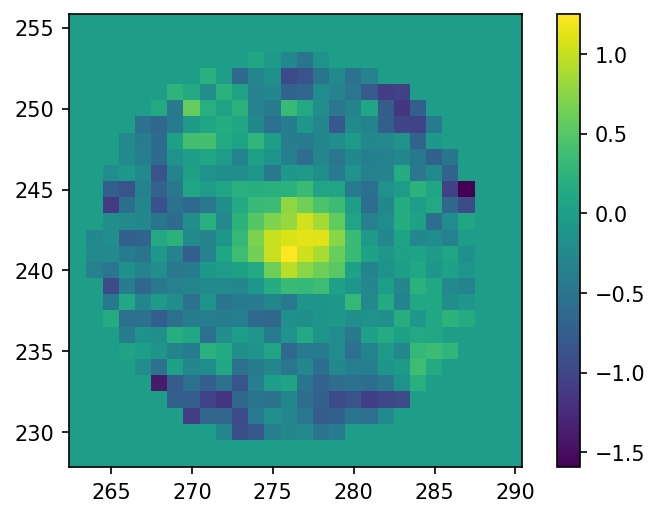

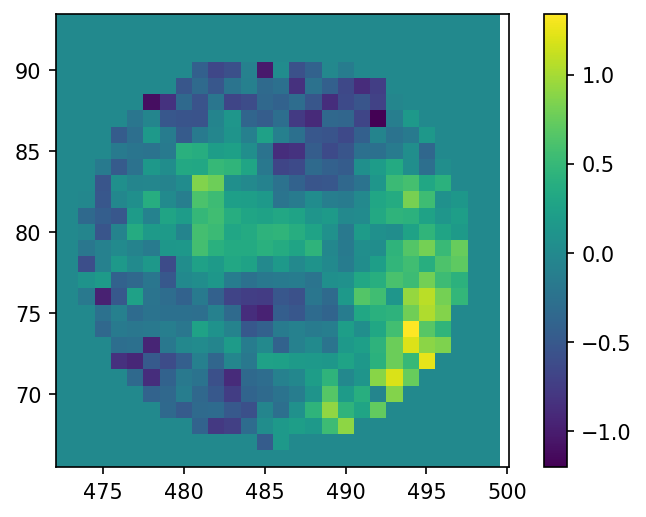

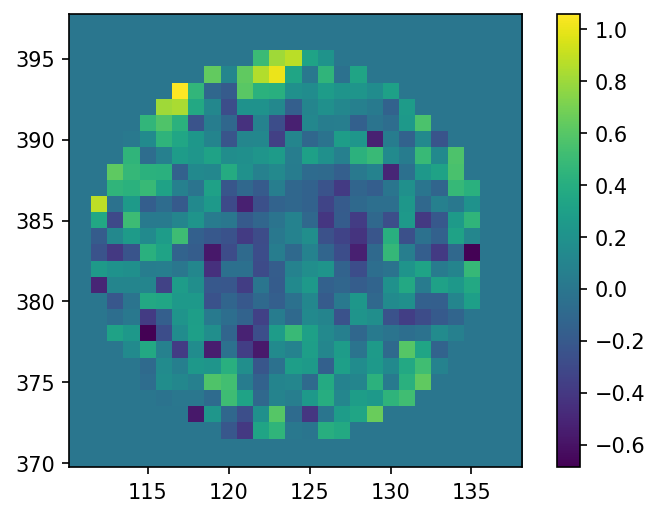

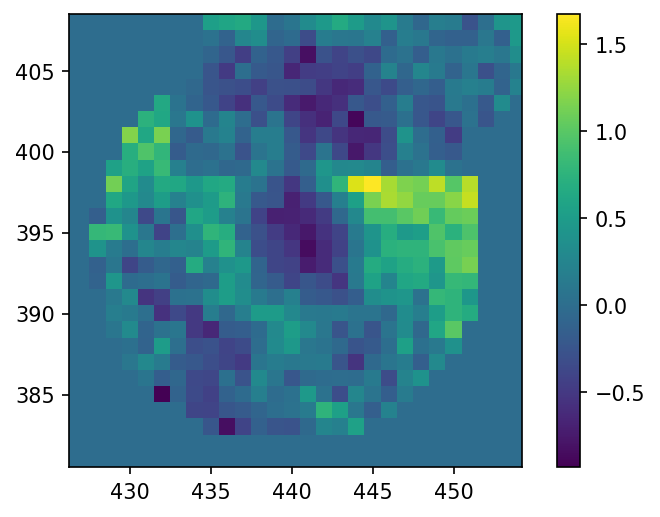

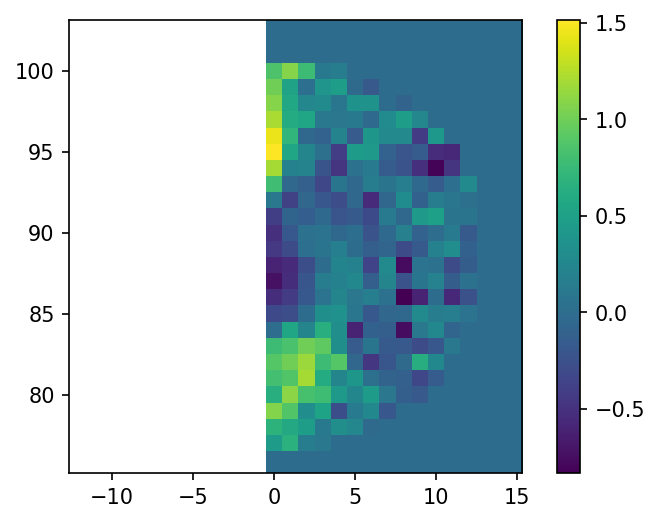

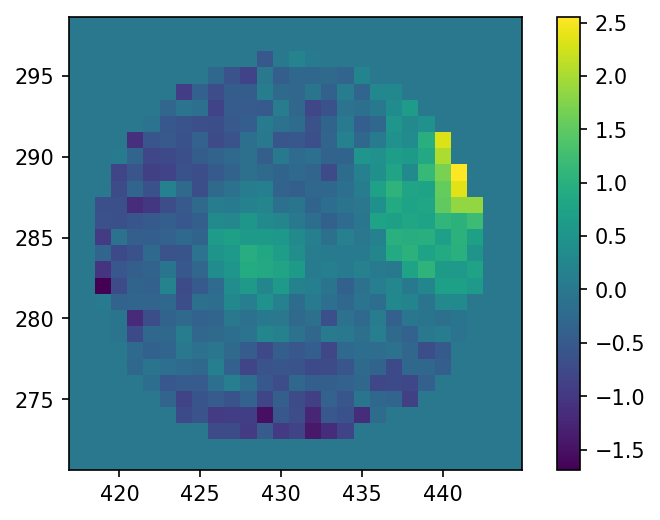

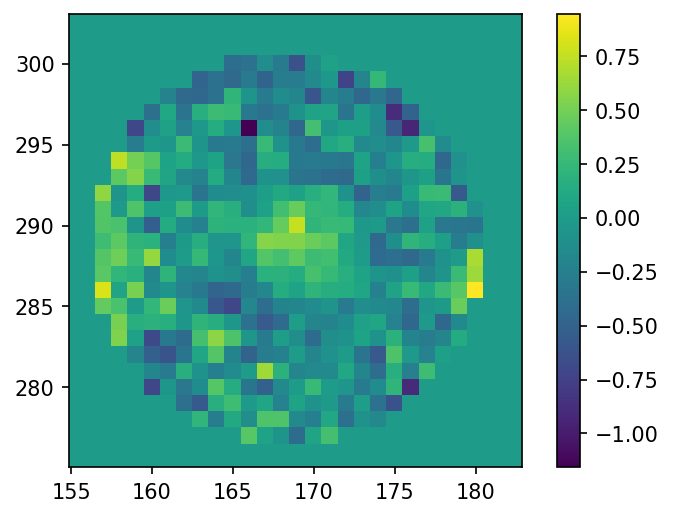

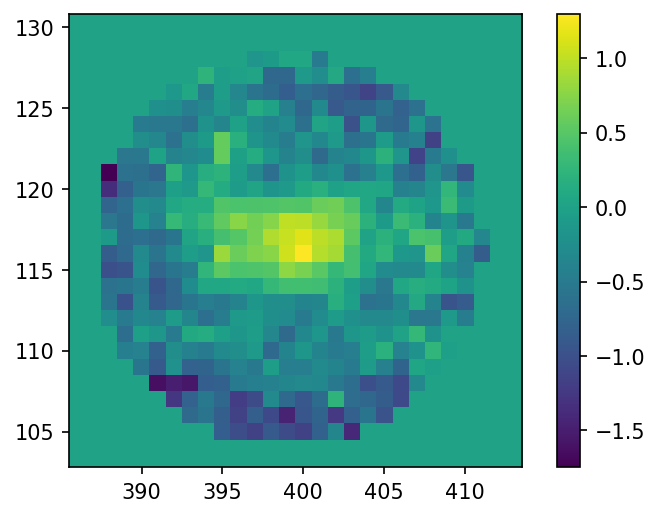

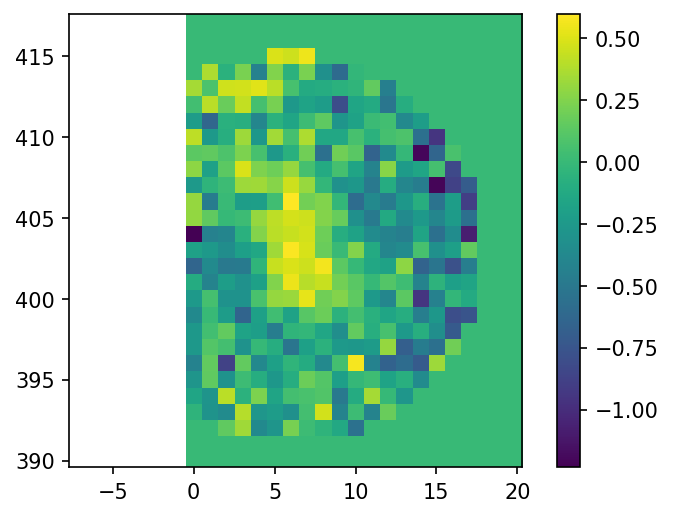

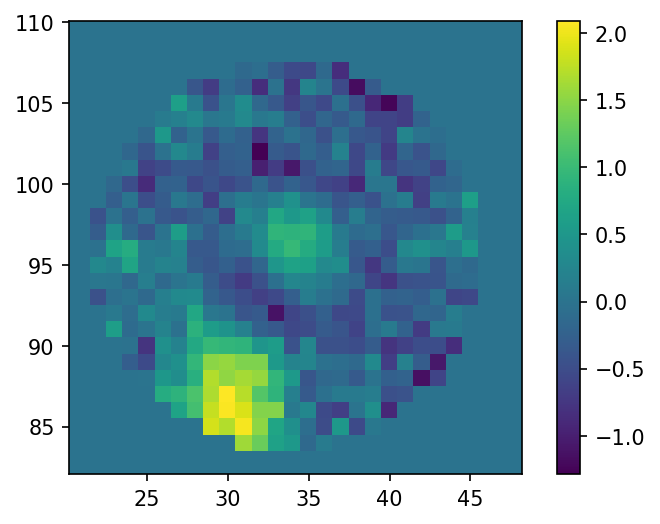

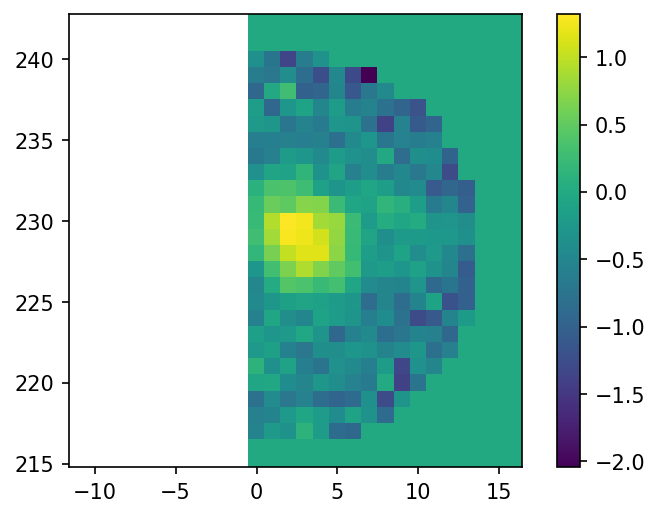

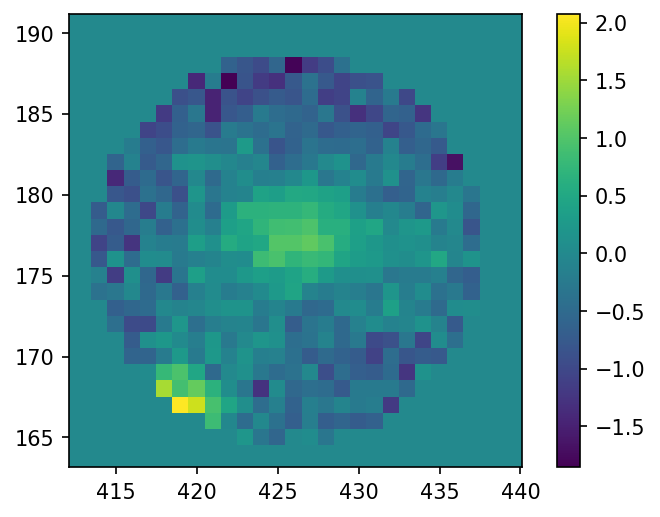

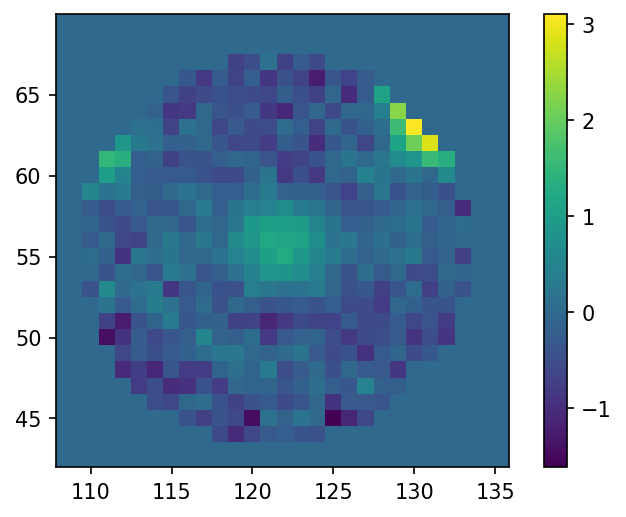

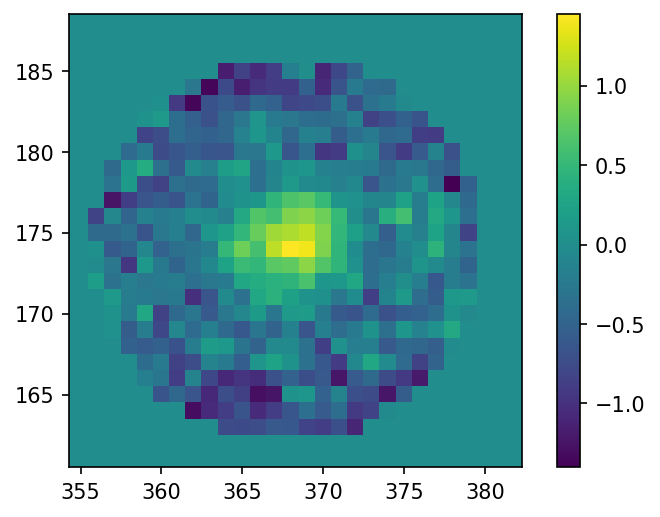

In [37]:
width = psf_full_extent // 2
for xcent, ycent in zip(xcenters, ycenters):
    d_ = residual_image[int(np.fmax(ycent-width,0)):int(ycent+width), int(np.fmax(xcent-width, 0)):int(xcent+width)] 
    vmin, vmax = np.min(d_), np.max(d_)
    #if vmax>10:
    #vmin, vmax = -3, 3
    plt.figure()
    plt.xlim(xcent-width-1, xcent+width+1)
    plt.ylim(ycent-width-1, ycent+width+1)
    plt.imshow(residual_image, origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()

## fit the traget with one- and two-star models

In [113]:
w_targ = 8
d_targ = jnp.array(np.array(d_cut[y_targ-w_targ:y_targ+w_targ, x_targ-w_targ:x_targ+w_targ]).astype(np.float64))
image_targ = PixelImage(*np.shape(d_targ))
image_targ.Z = d_targ 
image_targ.Zerr = jnp.sqrt(d_targ)

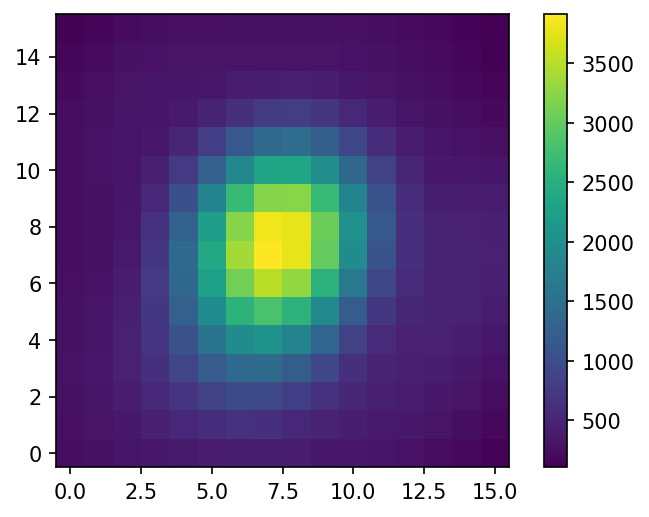

In [114]:
plt.imshow(d_targ, origin='lower')
plt.colorbar()

In [115]:
from jax import random
import numpyro
import numpyro.distributions as dist

def model_onestar():
    logf1 = numpyro.sample('logf1', dist.Uniform(1., 6))
    f1 = numpyro.deterministic("f1", 10**logf1)
    x1 = numpyro.sample("x1", dist.Uniform(5, 15))
    y1 = numpyro.sample("y1", dist.Uniform(3, 15))
    norms = jnp.array([f1])
    xcenters = jnp.array([x1])
    ycenters = jnp.array([y1])
    fluxmodel = numpyro.deterministic("fluxmodel", gridpsf.get_obs1d(norms, xcenters, ycenters, image_targ.X1d, image_targ.Y1d, epsf1d_pred))
    numpyro.sample("obs", dist.Normal(fluxmodel, image_targ.Zerr1d), obs=image_targ.Z1d)

def model_twostars():
    logf1 = numpyro.sample('logf1', dist.Uniform(1., 6))
    logf2 = numpyro.sample('logf2', dist.Uniform(1., 6))
    f1 = numpyro.deterministic("f1", 10**logf1)
    f2 = numpyro.deterministic("f2", 10**logf2)
    x1 = numpyro.sample("x1", dist.Uniform(5, 15))
    y1 = numpyro.sample("y1", dist.Uniform(3, 15))
    x2 = numpyro.sample("x2", dist.Uniform(x1, 15))
    y2 = numpyro.sample("y2", dist.Uniform(3, 15))
    norms = jnp.array([f1, f2])
    xcenters = jnp.array([x1, x2])
    ycenters = jnp.array([y1, y2])
    fluxmodel = numpyro.deterministic("fluxmodel", gridpsf.get_obs1d(norms, xcenters, ycenters, image_targ.X1d, image_targ.Y1d, epsf1d_pred))
    numpyro.sample("obs", dist.Normal(fluxmodel, image_targ.Zerr1d), obs=image_targ.Z1d)

In [131]:
kernel = numpyro.infer.NUTS(model_onestar, target_accept_prob=0.9)
nw = ns = 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 1000/1000 [00:07<00:00, 141.20it/s, 7 steps of size 2.52e-01. acc. prob=0.95]


In [132]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     logf1      5.35      0.00      5.35      5.35      5.36    500.98      1.00
        x1      7.86      0.01      7.86      7.85      7.87    301.22      1.00
        y1      7.40      0.01      7.40      7.39      7.41    399.72      1.00

Number of divergences: 0


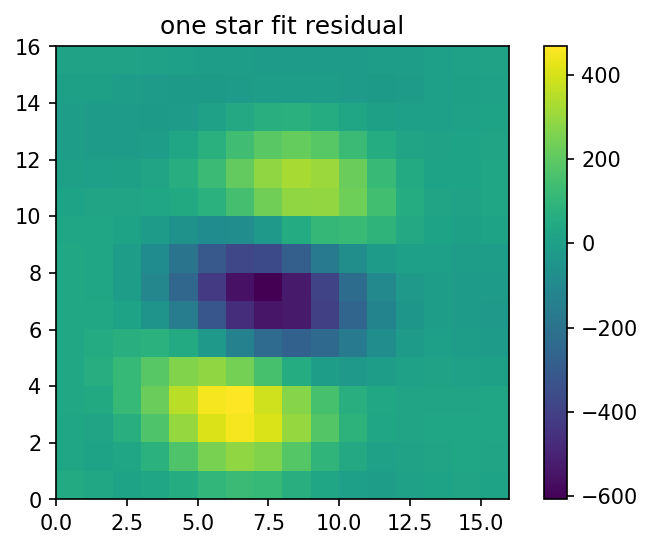

In [133]:
samples = mcmc.get_samples()
mean_image = np.mean(samples['fluxmodel'], axis=0)
res1d = (image_targ.Z1d - mean_image) #/ image_targ.Zerr1d

shape = image_targ.shape
plt.title("one star fit residual")
plt.imshow((res1d.reshape(shape)), origin='lower', extent=[0,16,0,16])
plt.colorbar()

In [134]:
xc, yc = np.mean(samples['x1']), np.mean(samples['y1'])

In [136]:
kernel = numpyro.infer.NUTS(model_twostars, target_accept_prob=0.9)
nw = ns = 500
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/masuda/anaconda3/lib/python3.9/site-packages/jax/_src/tree_util.py:200: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 1000/1000 [00:17<00:00, 56.25it/s, 15 steps of size 1.49e-01. acc. prob=0.94]


In [137]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     logf1      4.75      0.01      4.75      4.73      4.76    123.51      1.00
     logf2      5.25      0.00      5.25      5.25      5.26    130.87      1.00
        x1      7.01      0.03      7.01      6.96      7.06    171.17      1.00
        x2      8.06      0.01      8.06      8.04      8.08    228.10      1.00
        y1      4.64      0.05      4.64      4.57      4.73    135.27      1.00
        y2      8.07      0.02      8.07      8.05      8.10    136.95      1.00

Number of divergences: 0


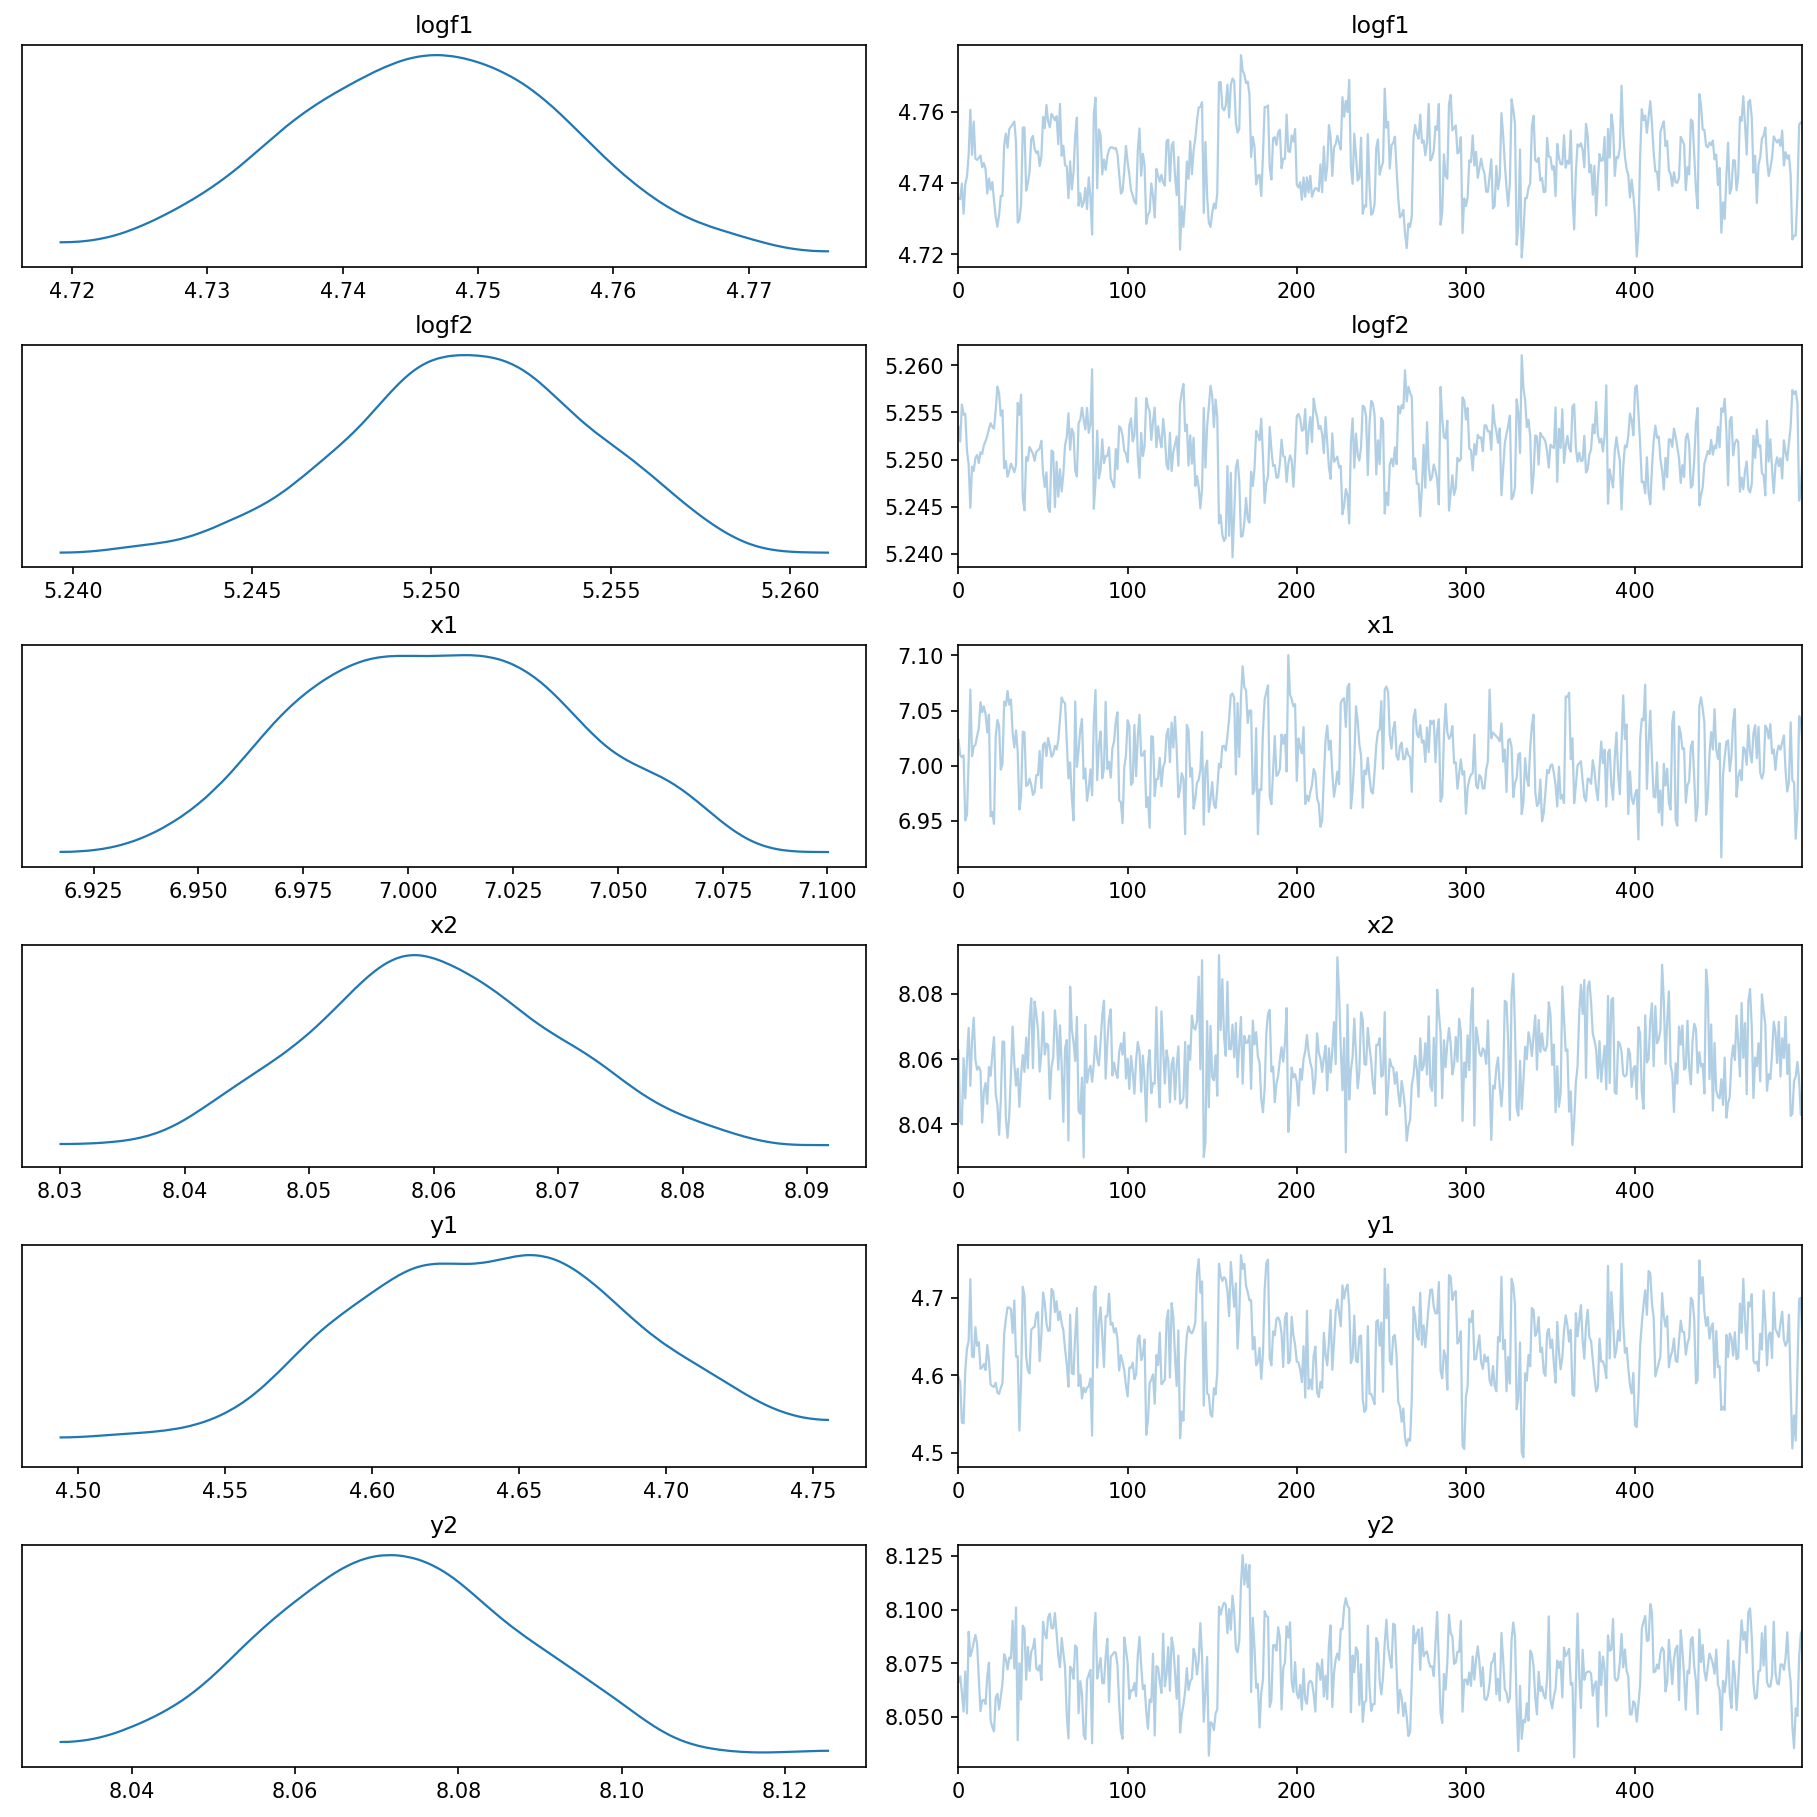

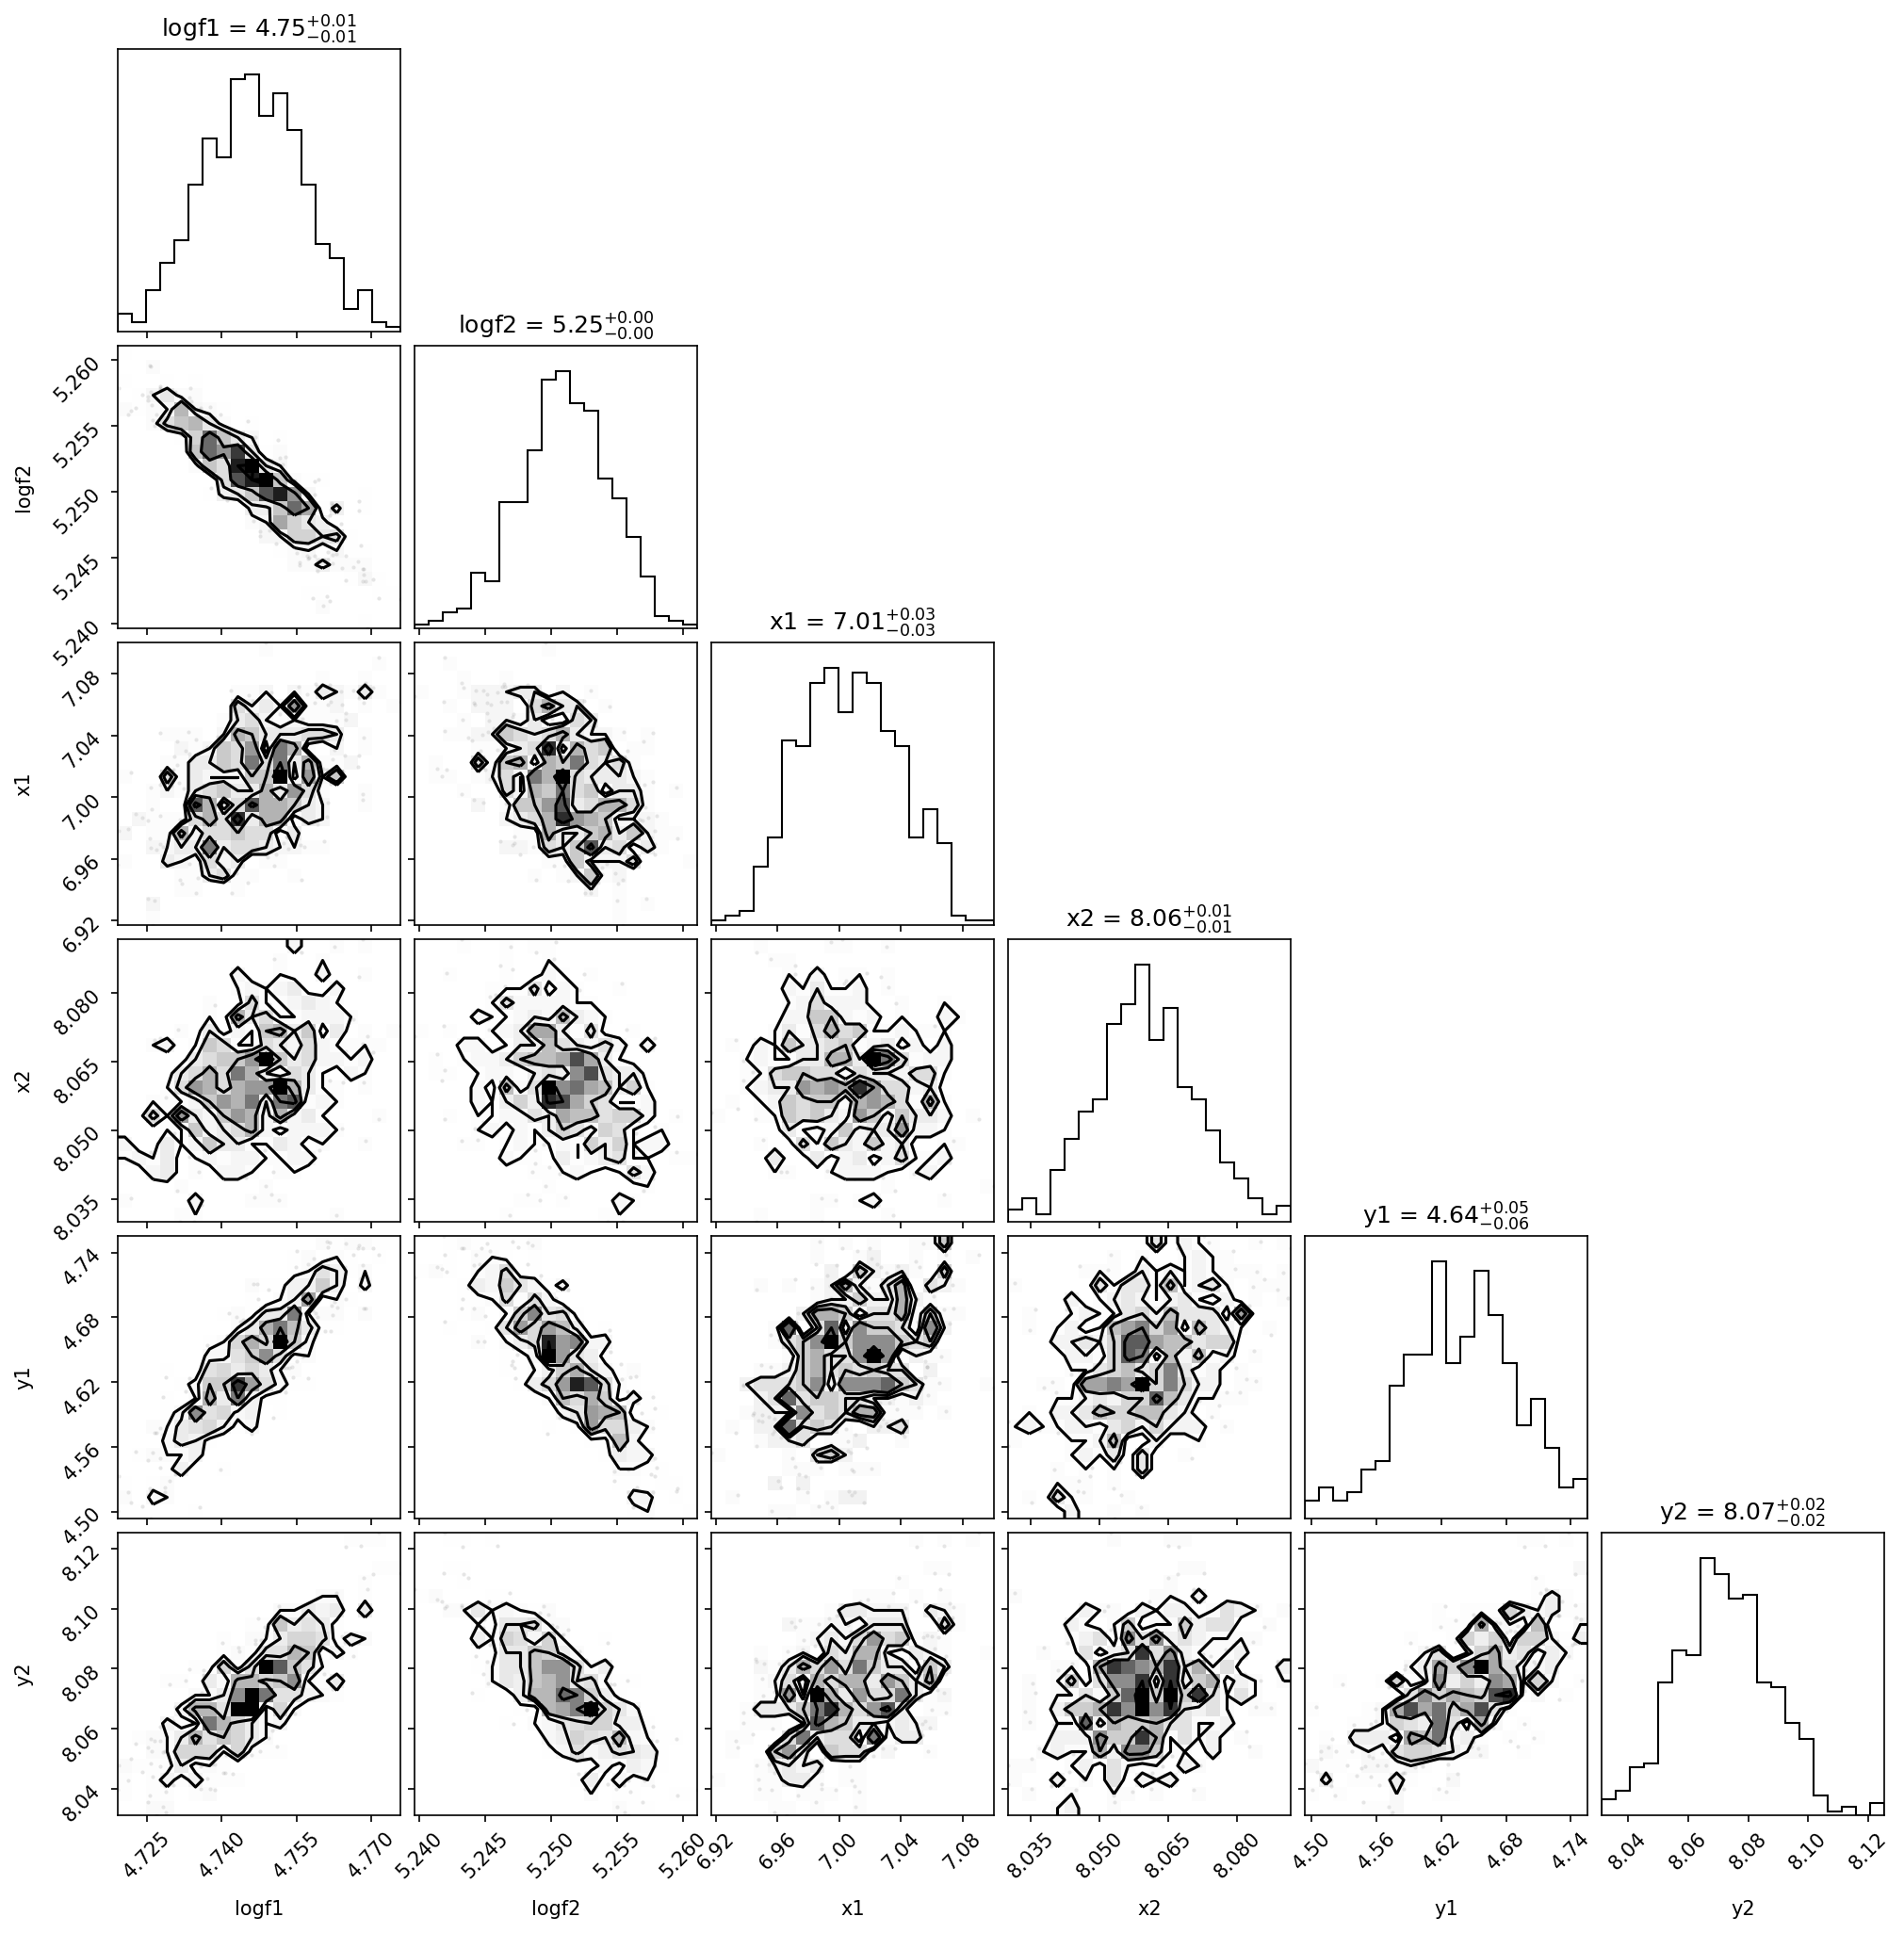

In [138]:
check_mcmc_hyperparameters(mcmc, pnames=['logf1', 'logf2', 'x1', 'x2', 'y1', 'y2'])

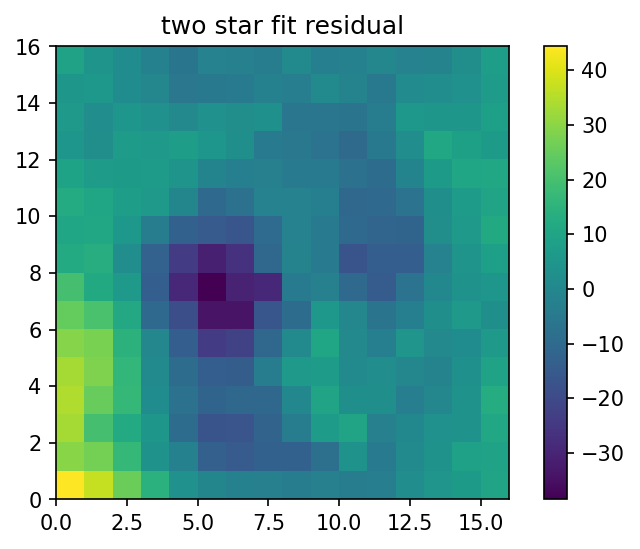

In [139]:
samples = mcmc.get_samples()
mean_image = np.mean(samples['fluxmodel'], axis=0)
res1d = image_targ.Z1d - mean_image #/ image_targ.Zerr1d

shape = image_targ.shape
plt.title("two star fit residual")
plt.imshow((res1d.reshape(shape)), origin='lower', extent=[0,16,0,16])
plt.colorbar()

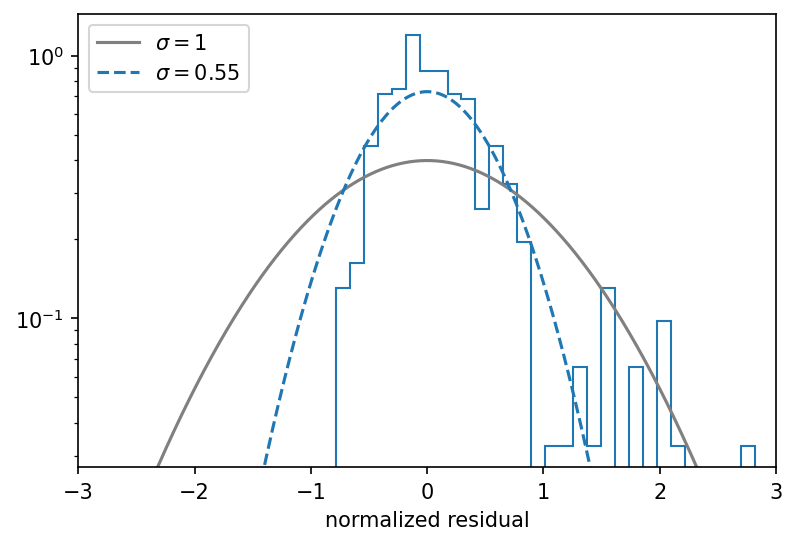

In [140]:
from scipy.stats import norm
normres = np.array(res1d/image_targ.Zerr1d)
x0 = np.linspace(-4, 4, 1000)
plt.xlabel("normalized residual")
plt.yscale("log")
plt.hist(normres, histtype='step', density=True, bins=30)
plt.ylim(plt.gca().get_ylim())
plt.plot(x0, norm.pdf(x0), color='gray', label='$\sigma=1$')
plt.xlim(-3, 3)
sigma = np.std(normres)
plt.plot(x0, norm(scale=sigma).pdf(x0), label='$\sigma=%.2f$'%sigma, color='C0', ls='dashed')
plt.legend(loc='best')

In [141]:
xs = [np.mean(samples['x%d'%i]) for i in range(1,3)]
ys = [np.mean(samples['y%d'%i]) for i in range(1,3)]

/tmp/ipykernel_1441745/3686153662.py:3: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(xs, ys, '.', marker='*', color='tan', label='two-star fit')
/tmp/ipykernel_1441745/3686153662.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(xc, yc, '.', marker='o', color='tan', label='one-star fit')


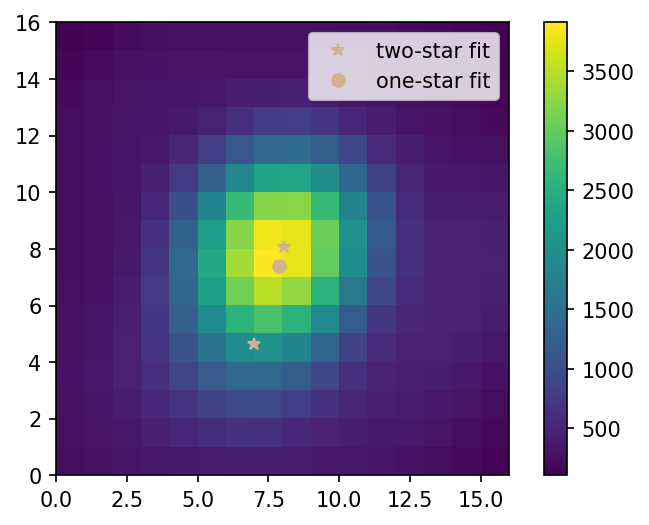

In [142]:
#plt.imshow((mean_image.reshape(shape)), origin='lower')
plt.imshow((image_targ.Z), origin='lower', extent=[0,16,0,16])
plt.plot(xs, ys, '.', marker='*', color='tan', label='two-star fit')
plt.plot(xc, yc, '.', marker='o', color='tan', label='one-star fit')
plt.colorbar()
plt.legend()

In [145]:
d12 = np.sqrt((samples['x1']-samples['x2'])**2 + (samples['y1']-samples['y2'])**2)
f_ratio = samples['f1'] / samples['f2']

In [147]:
print ("distance (pixel): %.2f +/- %.2f"%(np.mean(d12), np.std(d12)))
print ("flux ratio: %.2f +/- %.2f"%(np.mean(f_ratio), np.std(f_ratio)))

distance (pixel): 3.59 +/- 0.04
flux ratio: 0.31 +/- 0.01
